# Introduction

Short notebook to get an overview of model performance across architectures and dimensionality. 

In [ ]:
# colab setup:

!git clone https>

In [70]:
# general setup:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from NM_TinyRNN.code.models import parallelised_training as pat
from pathlib import Path
from importlib import reload

### Model performance and selection

Models are trained on 80% training data, with early stopping on 10% validation data, before computing a performance score on the last 10% evaluation data.

We do this with 10 random seeds and select the median performing model, for each architecture, in order to avoid overfitting on the data splits.

These 'median' models are then investigated further.

In [71]:
# you've trained a bunch of models with pat

reload(pat)
#pat.run_training(overwrite=True)

#Here we append the evaluation performance to the model info dataframe

info_df = pat.get_train_info_df()
evals = []
seeds = []
for model_info in info_df.itertuples():
    model_dir = Path(model_info.save_path)
    eval_json_path = model_dir / f'{model_info.model_id}_info.json'
    if eval_json_path.exists():
        with open(eval_json_path, 'r') as f:
            eval_info = json.load(f)
        evals.append(eval_info['eval_pred_loss'])
    else:
        evals.append(np.nan)
info_df['eval_CE'] = evals
#open the json and extract eval performance for each model:

Submitting model training for WS16 to HPC
Submitted batch job 1280229
Submitting model training for WS16 to HPC
Submitted batch job 1280230
Submitting model training for WS16 to HPC
Submitted batch job 1280231
Submitting model training for WS16 to HPC
Submitted batch job 1280232
Submitting model training for WS16 to HPC
Submitted batch job 1280233
Submitting model training for WS16 to HPC
Submitted batch job 1280234
Submitting model training for WS16 to HPC
Submitted batch job 1280235
Submitting model training for WS16 to HPC
Submitted batch job 1280236
Submitting model training for WS16 to HPC
Submitted batch job 1280237
Submitting model training for WS16 to HPC
Submitted batch job 1280238
Submitting model training for WS16 to HPC
Submitted batch job 1280239
Submitting model training for WS16 to HPC
Submitted batch job 1280240
Submitting model training for WS16 to HPC
Submitted batch job 1280241
Submitting model training for WS16 to HPC
Submitted batch job 1280242
Submitting model tra

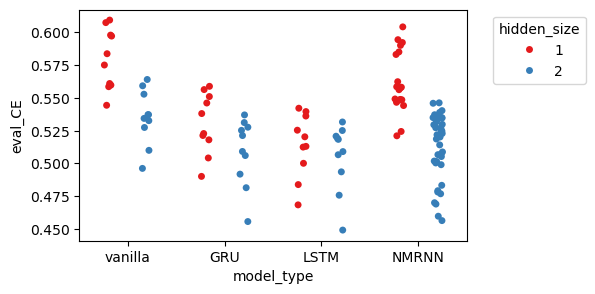

In [73]:
#Plot model performance across seeds and architectures:

plt.figure(figsize=(5,3))
ax = sns.stripplot(
    data=info_df,  
    y='eval_CE', 
    x='model_type',
    hue='hidden_size',
    jitter=True,
    dodge=True, palette='Set1',
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='hidden_size')
plt.show()

In [74]:
## Code to get 'median_df' and copy over the median-performing models for testing and comparisons

def closest_to_median(subdf):
    med = subdf["eval_CE"].median()
    idx = (subdf["eval_CE"] - med).abs().idxmin()
    return subdf.loc[idx, :]

median_df = info_df.groupby("model_id").apply(closest_to_median).reset_index(drop=True)
median_df

import os
import shutil
from pathlib import Path

def copy_median_models(df, example_path):
    """
    Copy median performing model files into EXAMPLE_PATH/<model_type>/.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns ['save_path', 'model_type', 'model_ID'].
        save_path should be a pathlib.Path pointing to the model directory.
    example_path : str or Path
        Parent directory where copies will be stored.
    """
    example_path = Path(example_path)
    example_path.mkdir(parents=True, exist_ok=True)

    # files we want to copy for each model
    file_suffixes = [
        "_info.json",
        "_model_state.pth",
        "_training_losses.htsv",
        "_trials_data.htsv",
    ]
    
    for _, row in df.iterrows():
        save_path = Path(row["save_path"])
        model_type = row["model_type"]
        model_id = row["model_id"]

        # make sure destination subfolder exists
        dest_dir = example_path / model_type
        dest_dir.mkdir(parents=True, exist_ok=True)

        for suffix in file_suffixes:
            src = save_path / f"{model_id}{suffix}"
            dst = dest_dir / f"{model_id}{suffix}"
            if src.exists():
                shutil.copy(src, dst)
                print(f"Copied {src} → {dst}")
            else:
                print(f"Warning: {src} not found!")

# Example usage:
#copy_median_models(median_df, Path('./NM_TinyRNN/data/rnns/example'))


/tmp/ipykernel_3135/1578142357.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_df = info_df.groupby("model_id").apply(closest_to_median).reset_index(drop=True)


## Investigating median models

In [8]:
# Let's get the trial-by-trial data for each example:
# in the above codeblock we get median_df

all_trials_data = {}

for each_model in median_df.itertuples():
    print(each_model.save_path)
    trials_data = pd.read_csv(each_model.save_path/f'{each_model.model_id}_trials_data.htsv',sep='\t')
    all_trials_data[each_model.model_id] = trials_data


NM_TinyRNN/data/rnns/WS16/random_seed_3/GRU
NM_TinyRNN/data/rnns/WS16/random_seed_3/LSTM
NM_TinyRNN/data/rnns/WS16/random_seed_1/NMRNN/low_rank
NM_TinyRNN/data/rnns/WS16/random_seed_1/NMRNN/low_rank
NM_TinyRNN/data/rnns/WS16/random_seed_1/vanilla
NM_TinyRNN/data/rnns/WS16/random_seed_3/GRU
NM_TinyRNN/data/rnns/WS16/random_seed_3/LSTM
NM_TinyRNN/data/rnns/WS16/random_seed_3/NMRNN/low_rank
NM_TinyRNN/data/rnns/WS16/random_seed_3/NMRNN/low_rank
NM_TinyRNN/data/rnns/WS16/random_seed_3/NMRNN/low_rank
NM_TinyRNN/data/rnns/WS16/random_seed_3/NMRNN/low_rank
NM_TinyRNN/data/rnns/WS16/random_seed_1/vanilla


/tmp/ipykernel_1550740/2275688174.py:27: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


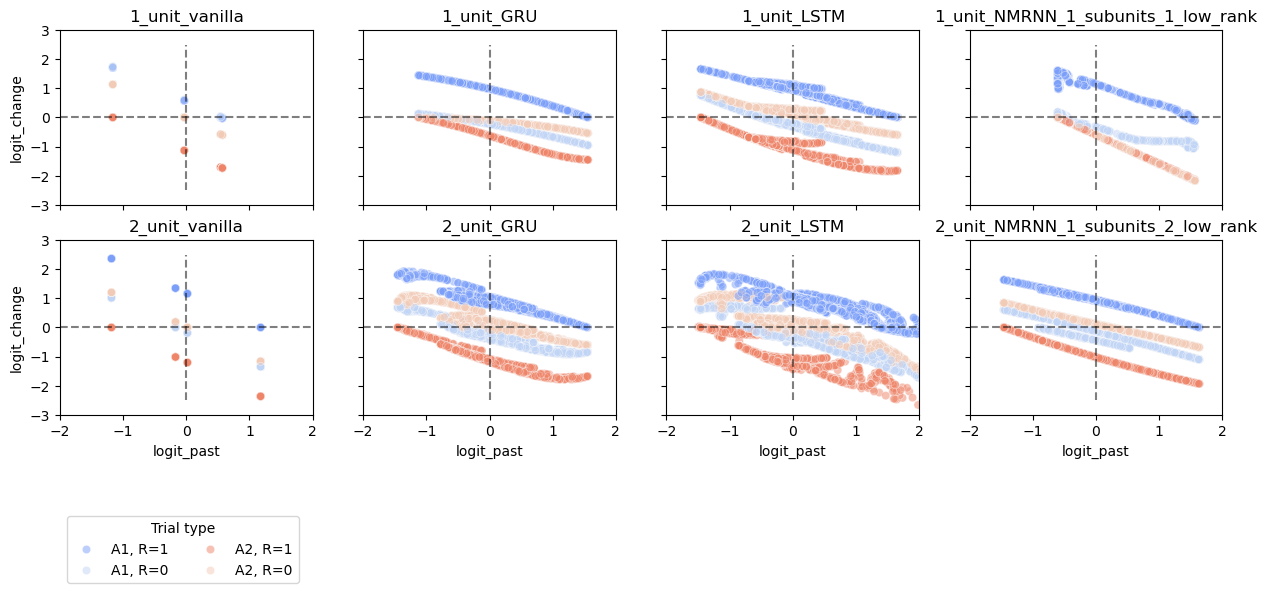

In [33]:
# plotting logits for 1 unit and 2 unit standard architectures
model_ids = ['1_unit_vanilla','1_unit_GRU','1_unit_LSTM','1_unit_NMRNN_1_subunits_1_low_rank',
             '2_unit_vanilla','2_unit_GRU','2_unit_LSTM','2_unit_NMRNN_1_subunits_2_low_rank']

fig, axes = plt.subplots(2,4, figsize = (15,5), sharex=True, sharey=True)
flat_ax = axes.flatten()

palette = sns.color_palette('coolwarm',4)
palette[2],palette[3] = palette[3], palette[2] #reordercolorpalette
for i,each_model in enumerate(model_ids):
    df = all_trials_data[each_model]
    sns.scatterplot(df, x='logit_past',y='logit_change',hue='trial_type',
                    palette=palette ,ax=flat_ax[i], alpha  = 0.5,)
    flat_ax[i].set(title = f'{each_model}', xlim = (-2,2),ylim=(-3,3))
    flat_ax[i].vlines(x=0,ymin=-2.5,ymax=2.5, 
                      linestyle = '--', color = 'black',alpha =0.5)
    flat_ax[i].hlines(y=0, xmin=-2,xmax=2,
                      linestyle = '--', color = 'black',alpha =0.5)
    
    if i==0:
        sns.move_legend( flat_ax[i], "lower left",
                        bbox_to_anchor=(0.0, -2.2), ncol=2, 
                        title='Trial type', frameon=True, )
    else:
        flat_ax[i].get_legend().remove()
        
fig.tight_layout()

from the above plots, we can see that tiny vanilla RNNs learn a 'win-stay-loose-shift' strategy. Recall that doesn't capture the data (mouse behaviour) as well as the other models. 

The 1 unit GRU seems to learn a non-linear state dependent update rule. The mouse seems to be more persistent at A2 (logit = -1), since it doesn't change its behaviour even if it is unrewarded (logit_change = 0 whenever R=0). However, for pokes at A1 (logit = 1), the mouse will shift its behaviour when unrewarded.

Note, however, that this strategy is not adopted by the LSTM, which fits the behaviour slightly better. Here the subtle behavioural bias is seen as an indifference in the update for unrewarded A2 pokes (same but still positive logiti change whenever R=0). At the same time, there is a more non-linear (flatter) update rule for A1 pokes. 


Another way we ought to be able to visualise this is that the attractor well for A2 pokes is deeper than the attractor state for A1 pokes.

## GRU state-dependent dynamics

The gated recurrent unit can update its state depending on the reset and update gate value.

Let's take a closer look at the recurrent update for different reset and update gate states.
